In [2]:
!pip install -q transformers datasets evaluate bert-score accelerate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 7.0 MB/s eta 0:00:00


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForSeq2SeqLM,
    Seq2SeqTrainer, Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq, set_seed
)
import evaluate

# لضمان إعادة إنتاج النتائج
set_seed(42)


In [4]:
dataset = load_dataset("karimraouf/Arabic-Summarization-Dataset-AsDs")

print(dataset)
print(dataset["train"][0])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-0e6e9af3a88227(…):   0%|          | 0.00/3.47M [00:00<?, ?B/s]

data/validation-00000-of-00001-9eb13f38d(…):   0%|          | 0.00/441k [00:00<?, ?B/s]

data/test-00000-of-00001-bffbaf820797229(…):   0%|          | 0.00/441k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2075 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/259 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/260 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['title', 'article', 'summary', 'topic'],
        num_rows: 2075
    })
    validation: Dataset({
        features: ['title', 'article', 'summary', 'topic'],
        num_rows: 259
    })
    test: Dataset({
        features: ['title', 'article', 'summary', 'topic'],
        num_rows: 260
    })
})
{'title': 'السريالية: رحلة إلى أعماق العقل الباطن والأحلام', 'article': "السريالية هي حركة ثقافية وفنية انطلقت في باريس في أوائل عشرينيات القرن الماضي، وكان الشاعر أندريه بريتون هو منظرها الرئيسي. تأثرت الحركة بشدة بنظريات سيغموند فرويد حول العقل الباطن والأحلام، وسعت إلى تحرير الفكر والخيال من قيود العقل والمنطق والعادات المجتمعية. الهدف كان الوصول إلى 'واقع فائق' (sur-reality) من خلال دمج عالم الأحلام وعالم اليقظة. استخدم الفنانون والكتاب السرياليون تقنيات مختلفة لإطلاق العنان لعقلهم الباطن. من أشهر هذه التقنيات 'الكتابة الآلية' (Automatism)، حيث يتم الكتابة أو الرسم بسرعة دون تفكير واعٍ. كما استخدموا تقنية تجميع الأشياء غير المترابطة معا

In [5]:
MODEL_NAME = "UBC-NLP/AraT5v2-base-1024"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

print("Using device:", device)


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

Using device: cuda


In [6]:
max_input_length = 1024    # الحد الأقصى للنص الأصلي
max_target_length = 128    # طول الملخص المرجعي أثناء التدريب

def preprocess_function(examples):
    inputs = examples["article"]
    targets = examples["summary"]

    model_inputs = tokenizer(
        inputs,
        max_length=max_input_length,
        truncation=True,
        padding="max_length"
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=max_target_length,
            truncation=True,
            padding="max_length"
        )

    # تجاهل padding أثناء حساب الخسارة
    labels_ids = [
        [(lid if lid != tokenizer.pad_token_id else -100) for lid in label]
        for label in labels["input_ids"]
    ]

    model_inputs["labels"] = labels_ids
    return model_inputs


In [7]:
tokenized_train = dataset["train"].map(
    preprocess_function,
    batched=True,
    remove_columns=dataset["train"].column_names
)

tokenized_val = dataset["validation"].map(
    preprocess_function,
    batched=True,
    remove_columns=dataset["validation"].column_names
)


Map:   0%|          | 0/2075 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4169: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/259 [00:00<?, ? examples/s]

In [8]:
!pip install rouge_score
rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    preds, labels = eval_pred

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(
        predictions=decoded_preds,
        references=decoded_labels
    )

    # تحويل النتائج إلى نسب مئوية
    return {k: round(v * 100, 4) for k, v in result.items()}


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=b765fb35e432ab5d4339bb8f22b37c97d34cd5b9c38ef9b5a052773da7148260
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [9]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,

    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,

    weight_decay=0.01,
    predict_with_generate=True,

    fp16=torch.cuda.is_available(),
    logging_steps=50,
    report_to="none"
)

In [10]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


/tmp/ipython-input-272938047.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [11]:
trainer.train()


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,2.417000,1.710556,1.287000,0.264800,1.322200,1.329900
2,2.163600,1.612906,2.474100,0.485400,2.429700,2.466800
3,1.993200,1.573544,1.835500,0.264800,1.780400,1.812500


TrainOutput(global_step=3114, training_loss=2.526311143055587, metrics={'train_runtime': 2760.0324, 'train_samples_per_second': 2.255, 'train_steps_per_second': 1.128, 'total_flos': 1.08186912423936e+16, 'train_loss': 2.526311143055587, 'epoch': 3.0})

In [13]:
from google.colab import drive
drive.mount('/content/drive')

# حفظ محلي
trainer.save_model("./arabic_summarizer_model")
tokenizer.save_pretrained("./arabic_summarizer_model")

# حفظ على Google Drive
model.save_pretrained("/content/drive/MyDrive/arabic_summarizer_model")
tokenizer.save_pretrained("/content/drive/MyDrive/arabic_summarizer_model")


Mounted at /content/drive


('/content/drive/MyDrive/arabic_summarizer_model/tokenizer_config.json',
 '/content/drive/MyDrive/arabic_summarizer_model/special_tokens_map.json',
 '/content/drive/MyDrive/arabic_summarizer_model/spiece.model',
 '/content/drive/MyDrive/arabic_summarizer_model/added_tokens.json')

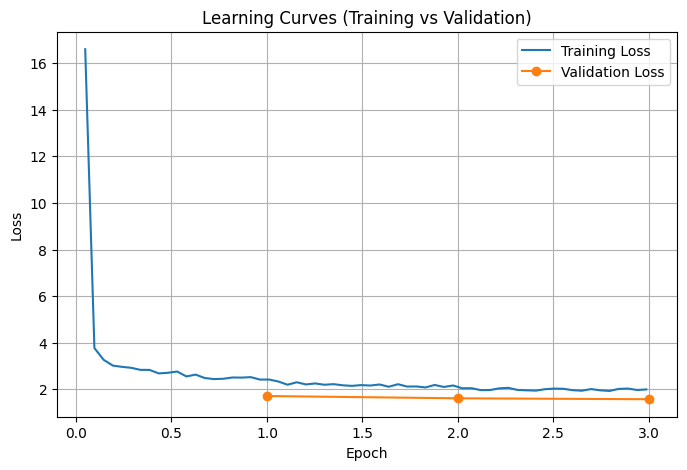

In [12]:
# استخراج السجلات
logs = trainer.state.log_history

# training loss مع رقم الخطوة
train_steps = []
train_loss = []

# validation loss مع رقم epoch
val_epochs = []
val_loss = []

for log in logs:
    if "loss" in log and "epoch" in log:
        train_steps.append(log["epoch"])
        train_loss.append(log["loss"])
    if "eval_loss" in log:
        val_epochs.append(log["epoch"])
        val_loss.append(log["eval_loss"])

# رسم منحنيات التعلم
plt.figure(figsize=(8,5))

plt.plot(train_steps, train_loss, label="Training Loss")
plt.plot(val_epochs, val_loss, marker="o", label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curves (Training vs Validation)")
plt.legend()
plt.grid(True)
plt.show()


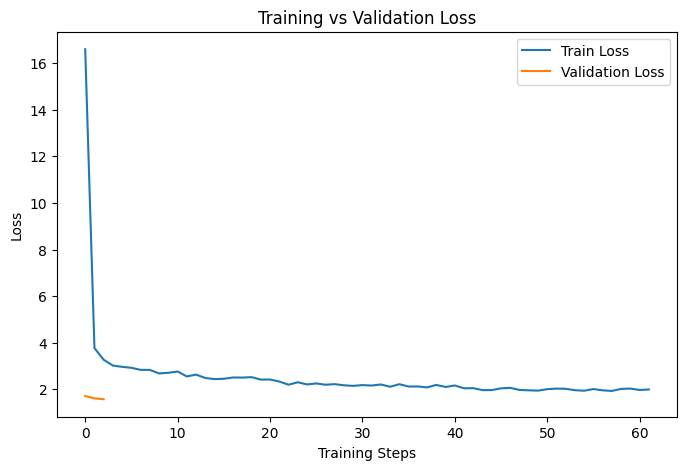

In [14]:
logs = trainer.state.log_history

train_loss = [x["loss"] for x in logs if "loss" in x]
val_loss = [x["eval_loss"] for x in logs if "eval_loss" in x]

plt.figure(figsize=(8,5))
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


In [29]:
def summarize_arabic(text):
    inputs = tokenizer_inf(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=max_input_length,
        padding=True   # ❗ لا تستخدم padding="max_length" هنا
    ).to(device)

    summary_ids = model_inf.generate(
        **inputs,
        min_length=20,          # خفّض الحد الأدنى
        max_length=200,
        num_beams=4,
        length_penalty=2.0,
        no_repeat_ngram_size=3,
        early_stopping=True
    )

    summary = tokenizer_inf.decode(
        summary_ids[0],
        skip_special_tokens=True
    )

    return summary.strip()


In [30]:
test_text = """إنَّ مفهوم التكنولوجيا أوسع من أنها مُجرد أجهزة حاسوب وهندسة، حيث إن التكنولوجيا تلامس كل شيء يقوم به الأشخاص يومياً مهما كانت اهتماماتهم الشخصية، ويُمكن تعريف التكنولوجيا على أنه فرع من أفرُع المعرفة التي تَعتَمِد على عملية الابتكار، واستخدام الوسائل التقنية الحديثة وربطها مع الحياة اليوميَّة والمجتمع والبيئة المُحيطة، وذلك بالاعتماد على الفنون الصناعية، والهندسة، والعلوم التطبيقيَّة، والعلوم البَحتة. كما يُمكن تعريف التكنولوجيا على أنها طريقة لإنجاز مُهمَّة ما من خلال استخدام الوسائل والأساليب التقنيَّة والمعارف المُتعددة. تأثير التكنولوجيا على العملية التعليمية أصبح تأثير التكنولوجيا كبير جداً على العمليَّة التعليمية منذ إدخال الإنترنت، حيث قامت العديد من الكليات وبرامج الدراسات العليا بإنشاء منصات للتعلم عبر الإنترنت، مما جعل عدد الطلاب الذين يتلقون دروساً عبر الإنترنت كبيراً، كما تُشجع التكنولوجيا الأشخاص على الابتكار وزيادة تعاونهم على التعلم، ومن الأمور التي توفرها التكنولوجيا للتعليم ما يلي: توافر الدرجات العلمية والشهادات على الانترنت (بالإنجليزية: Online Degrees). توافر المناهج على الإنترنت لذلك يُمكن تنظيم وقت الدراسة على حسب الظروف الشخصية (بالإنجليزية: Anticipated Study). توافر الموارد والمصادر الحديثة (بالإنجليزية: Modernized Resources). تأثير التكنولوجيا على الصحة يوجد العديد من التأثيرات للتكنولوجيا على صحة الإنسان، منها الإيجابيّ ومنها السلبي، ويُمكن تعداد أهم هذه التأثيرات كما يلي:[١] التكنولوجيا تجعل الأشخاص أكثر كَسَلاً: وذلك نتيجة للترفيه الدائم المُتواجد بين يَدي الأشخاص، إلَّا أن التكنولوجيا لا تجعل الأشخاص أكثر كسلاً عند استخدامها بالطُرُق الصحيحة حيث إنَّ التكنولوجيا تَسمح للمستخدمين بالوصول إلى المزيد من المعلومات بِشكل أكبر مما يمكن تصوره بنقرة زر واحدة فقط. الشاشات تؤثِّر على نَظَر الأشخاص: حيث إنَّ العديد من الأشخاص يعانون من عدم راحة العين بعد استخدام أي شَاشَة لمدة تزيد عن ساعتين مُتواصلتين، لكن ليس فقط العيون التي قد تتأثر باستخدام الشاشات، فقد تؤثر الشاشات أيضاً على كُل مِن الرأس والعُنق والكتفين، وذلك اعتمادًا على وضعيَّة الشخص أثناء استخدام شاشات الأجهزة المُختلفة. إذا احتاج الشخص قضاء 8 ساعات على الأقل يومياً أمام شاشة ما فيجب الالتزام بالنَّصائح التالية لتقليل إجهاد العين: وفقًا للقاعدة 20-20-20 ، يجب أخذ استراحة لمدة 20 ثانية من الشاشة كل 20 دقيقة والنظر إلى شيء يبعد 20 قدمًا أي 6 متر عن الشخص. القيام بتقليل الإضاءة الخاصة بِتَوَهُّج الشاشة. الجلوس مسافة ذراع واحد بعيدًا عن الشاشة للحصول على مسافة مناسبة عند استخدام شاشة الكمبيوتر. القيام بزيادة حجم النص على الأجهزة لتسهيل عرض المحتوى. التأثير على حياة العائلات: تُساهم التكنولوجيا بجعل كُل فرد من أفراد العائلة يَقضي مُعظم أوقاته وحيداً، وبعيداً عن بقيَّة الأفراد.[٢] التكنولوجيا ما بين الماضي والحاضر يُمكن القول أن كُل شيء يَتغير مع مرور الوقت، حيث أصبحت معظم الأمور الآن تَسير في طُرق مُختلفة عمَّا كانت عليه في العقود الماضيَة، حيث أن أصبح مُعظم اعتماد الأشخاص حاليّاً على التكنولوجيا، ويُمكن تلخيص أهم الجوانب التي اختلفت من حيث التكنولوجيا ما بين الماضي والحاضر هي:[٣] الاتصالات (بالإنجليزية: Communication): لقد كانت عمليات الاتصالات سابِقاً مُعتمِدة على البريد الكسول (بالإنجليزية: Snail mail)، حيث قد كان شائِعاً بين الأصدقاء المُراسلة عبر البريد الكسول، وكِتابة الرسائل يَدويَّاً مع وجود طواِبع بريدية عليها، وتُعد طريق المُراسة في البريد طريقة بطيئة وغير مُجدية النَّفع، أمَّا في وقتنا الحالي فقد أصبحت وسائل الاتصالات أكثر نفعاً وبِسرعة أكبر حيث تمَّ تَقصير وقت الاتصال من عِدَّة أيَّام إلى مجرد دقائق معدودة، وقد أصبح الاعتماد في هذه الأيام على كُل مِن البريد الإلكتروني أو الرسائل النصية أو الدردشة المرئية أو الفاكس أو الرسائل الفورية، وغيرها من التقنيات التي تسمح للأشخاص بالاتصال ببعضهم البعض دون الحاجة إلى العثور على صندوق بريد. وسائل النقل (بالإنجليزية: Transportation): لقد كانت وسائل النقل سابِقاُ غير مُريحة، حيث كانت أريح وسائل النقل هي العربات التي تجرها الخيول والسُفن، أمَّا الآن فإن جميع وسائل النقل تتمتَّع بالسرعة والأمان والراحة كاستخدام السيارات الحديثة أو الطائرات وغيرها. وسائل الترفيه (بالإنجليزية: Entertainment): لقد كانت المسرحيات هي الوسيلة الأفضل للترفيه سابِقاً، أمَّا الآن فإن جميع وسائل الترفيه الحديثة متواجدة، مثل: دُور السينما، والتلفزيون، وألعاب الفيديو، وتطبيقات الهاتف.
"""

print("Generated Summary:")
print(summarize(test_text))


Generated Summary:
يشرح المقال مفهوم التكنولوجيا على أنه فرع من المعرفة التي تُستخدم في كل شيء، ويُوضح كيف أن التكنولوجيا تُساعد الأشخاص على الابتكار وزيادة تعاونهم. يستعرض المقال التأثيرات الإيجابيّة للتكنولوجيا على التعليم، مثل توفير الدرجات العلمية والشهادات على الإنترنت، وتوفير الموارد الحديثة. ويستعرض المقال أهم الجوانب التي تختلف من الماضي إلى الحاضر، مثل الاتصالات، والنقل، والترفيه، حيث أصبحت معظم وسائل النقل الحديثة متوافرة، مثل السيارات الحديثة، ووسائل الترفيه الحديثة.


In [17]:
from bert_score import score

reference = ["إنَّ مفهوم التكنولوجيا أوسع من أنها مُجرد أجهزة حاسوب وهندسة، حيث إن التكنولوجيا تلامس كل شيء يقوم به الأشخاص يومياً مهما كانت اهتماماتهم الشخصية، ويُمكن تعريف التكنولوجيا على أنه فرع من أفرُع المعرفة التي تَعتَمِد على عملية الابتكار، واستخدام الوسائل التقنية الحديثة وربطها مع الحياة اليوميَّة والمجتمع والبيئة المُحيطة، وذلك بالاعتماد على الفنون الصناعية، والهندسة، والعلوم التطبيقيَّة، والعلوم البَحتة. كما يُمكن تعريف التكنولوجيا على أنها طريقة لإنجاز مُهمَّة ما من خلال استخدام الوسائل والأساليب التقنيَّة والمعارف المُتعددة. تأثير التكنولوجيا على العملية التعليمية أصبح تأثير التكنولوجيا كبير جداً على العمليَّة التعليمية منذ إدخال الإنترنت، حيث قامت العديد من الكليات وبرامج الدراسات العليا بإنشاء منصات للتعلم عبر الإنترنت، مما جعل عدد الطلاب الذين يتلقون دروساً عبر الإنترنت كبيراً، كما تُشجع التكنولوجيا الأشخاص على الابتكار وزيادة تعاونهم على التعلم، ومن الأمور التي توفرها التكنولوجيا للتعليم ما يلي: توافر الدرجات العلمية والشهادات على الانترنت (بالإنجليزية: Online Degrees). توافر المناهج على الإنترنت لذلك يُمكن تنظيم وقت الدراسة على حسب الظروف الشخصية (بالإنجليزية: Anticipated Study). توافر الموارد والمصادر الحديثة (بالإنجليزية: Modernized Resources). تأثير التكنولوجيا على الصحة يوجد العديد من التأثيرات للتكنولوجيا على صحة الإنسان، منها الإيجابيّ ومنها السلبي، ويُمكن تعداد أهم هذه التأثيرات كما يلي:[١] التكنولوجيا تجعل الأشخاص أكثر كَسَلاً: وذلك نتيجة للترفيه الدائم المُتواجد بين يَدي الأشخاص، إلَّا أن التكنولوجيا لا تجعل الأشخاص أكثر كسلاً عند استخدامها بالطُرُق الصحيحة حيث إنَّ التكنولوجيا تَسمح للمستخدمين بالوصول إلى المزيد من المعلومات بِشكل أكبر مما يمكن تصوره بنقرة زر واحدة فقط. الشاشات تؤثِّر على نَظَر الأشخاص: حيث إنَّ العديد من الأشخاص يعانون من عدم راحة العين بعد استخدام أي شَاشَة لمدة تزيد عن ساعتين مُتواصلتين، لكن ليس فقط العيون التي قد تتأثر باستخدام الشاشات، فقد تؤثر الشاشات أيضاً على كُل مِن الرأس والعُنق والكتفين، وذلك اعتمادًا على وضعيَّة الشخص أثناء استخدام شاشات الأجهزة المُختلفة. إذا احتاج الشخص قضاء 8 ساعات على الأقل يومياً أمام شاشة ما فيجب الالتزام بالنَّصائح التالية لتقليل إجهاد العين: وفقًا للقاعدة 20-20-20 ، يجب أخذ استراحة لمدة 20 ثانية من الشاشة كل 20 دقيقة والنظر إلى شيء يبعد 20 قدمًا أي 6 متر عن الشخص. القيام بتقليل الإضاءة الخاصة بِتَوَهُّج الشاشة. الجلوس مسافة ذراع واحد بعيدًا عن الشاشة للحصول على مسافة مناسبة عند استخدام شاشة الكمبيوتر. القيام بزيادة حجم النص على الأجهزة لتسهيل عرض المحتوى. التأثير على حياة العائلات: تُساهم التكنولوجيا بجعل كُل فرد من أفراد العائلة يَقضي مُعظم أوقاته وحيداً، وبعيداً عن بقيَّة الأفراد.[٢] التكنولوجيا ما بين الماضي والحاضر يُمكن القول أن كُل شيء يَتغير مع مرور الوقت، حيث أصبحت معظم الأمور الآن تَسير في طُرق مُختلفة عمَّا كانت عليه في العقود الماضيَة، حيث أن أصبح مُعظم اعتماد الأشخاص حاليّاً على التكنولوجيا، ويُمكن تلخيص أهم الجوانب التي اختلفت من حيث التكنولوجيا ما بين الماضي والحاضر هي:[٣] الاتصالات (بالإنجليزية: Communication): لقد كانت عمليات الاتصالات سابِقاً مُعتمِدة على البريد الكسول (بالإنجليزية: Snail mail)، حيث قد كان شائِعاً بين الأصدقاء المُراسلة عبر البريد الكسول، وكِتابة الرسائل يَدويَّاً مع وجود طواِبع بريدية عليها، وتُعد طريق المُراسة في البريد طريقة بطيئة وغير مُجدية النَّفع، أمَّا في وقتنا الحالي فقد أصبحت وسائل الاتصالات أكثر نفعاً وبِسرعة أكبر حيث تمَّ تَقصير وقت الاتصال من عِدَّة أيَّام إلى مجرد دقائق معدودة، وقد أصبح الاعتماد في هذه الأيام على كُل مِن البريد الإلكتروني أو الرسائل النصية أو الدردشة المرئية أو الفاكس أو الرسائل الفورية، وغيرها من التقنيات التي تسمح للأشخاص بالاتصال ببعضهم البعض دون الحاجة إلى العثور على صندوق بريد. وسائل النقل (بالإنجليزية: Transportation): لقد كانت وسائل النقل سابِقاُ غير مُريحة، حيث كانت أريح وسائل النقل هي العربات التي تجرها الخيول والسُفن، أمَّا الآن فإن جميع وسائل النقل تتمتَّع بالسرعة والأمان والراحة كاستخدام السيارات الحديثة أو الطائرات وغيرها. وسائل الترفيه (بالإنجليزية: Entertainment): لقد كانت المسرحيات هي الوسيلة الأفضل للترفيه سابِقاً، أمَّا الآن فإن جميع وسائل الترفيه الحديثة متواجدة، مثل: دُور السينما، والتلفزيون، وألعاب الفيديو، وتطبيقات الهاتف."]
generated = [summarize(test_text)]

P, R, F1 = score(generated, reference, lang="ar")

print("BERTScore F1:", F1.mean().item())

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

BERTScore F1: 0.7128080725669861


In [31]:
!pip install -q bert-score
from bert_score import score

reference_text = [test_text]
generated_summary = [summarize(test_text)]

P, R, F1 = score(
    generated_summary,
    reference_text,
    lang="ar"
)

print("BERTScore Precision:", P.mean().item())
print("BERTScore Recall:", R.mean().item())
print("BERTScore F1:", F1.mean().item())


BERTScore Precision: 0.7538155317306519
BERTScore Recall: 0.6969904899597168
BERTScore F1: 0.724290132522583


In [47]:
def evaluate_summary(generated, reference):
    rouge = evaluate.load("rouge")
    rouge_scores = rouge.compute(
        predictions=[generated],
        references=[reference]
    )

    from bert_score import score
    P, R, F1 = score([generated], [reference], lang="ar")

    return {
        "ROUGE-1": rouge_scores["rouge1"],
        "ROUGE-2": rouge_scores["rouge2"],
        "ROUGE-L": rouge_scores["rougeL"],
        "BERTScore-F1": F1.mean().item()
    }


In [32]:
def rouge_on_user_input(article, reference_summary):
    generated_summary = summarize(article)

    rouge = evaluate.load("rouge")
    scores = rouge.compute(
        predictions=[generated_summary],
        references=[reference_summary]
    )

    scores = {k: round(v * 100, 2) for k, v in scores.items()}

    return generated_summary, scores

In [33]:
user_text = """إنَّ مفهوم التكنولوجيا أوسع من أنها مُجرد أجهزة حاسوب وهندسة، حيث إن التكنولوجيا تلامس كل شيء يقوم به الأشخاص يومياً مهما كانت اهتماماتهم الشخصية، ويُمكن تعريف التكنولوجيا على أنه فرع من أفرُع المعرفة التي تَعتَمِد على عملية الابتكار، واستخدام الوسائل التقنية الحديثة وربطها مع الحياة اليوميَّة والمجتمع والبيئة المُحيطة، وذلك بالاعتماد على الفنون الصناعية، والهندسة، والعلوم التطبيقيَّة، والعلوم البَحتة. كما يُمكن تعريف التكنولوجيا على أنها طريقة لإنجاز مُهمَّة ما من خلال استخدام الوسائل والأساليب التقنيَّة والمعارف المُتعددة. تأثير التكنولوجيا على العملية التعليمية أصبح تأثير التكنولوجيا كبير جداً على العمليَّة التعليمية منذ إدخال الإنترنت، حيث قامت العديد من الكليات وبرامج الدراسات العليا بإنشاء منصات للتعلم عبر الإنترنت، مما جعل عدد الطلاب الذين يتلقون دروساً عبر الإنترنت كبيراً، كما تُشجع التكنولوجيا الأشخاص على الابتكار وزيادة تعاونهم على التعلم، ومن الأمور التي توفرها التكنولوجيا للتعليم ما يلي: توافر الدرجات العلمية والشهادات على الانترنت (بالإنجليزية: Online Degrees). توافر المناهج على الإنترنت لذلك يُمكن تنظيم وقت الدراسة على حسب الظروف الشخصية (بالإنجليزية: Anticipated Study). توافر الموارد والمصادر الحديثة (بالإنجليزية: Modernized Resources). تأثير التكنولوجيا على الصحة يوجد العديد من التأثيرات للتكنولوجيا على صحة الإنسان، منها الإيجابيّ ومنها السلبي، ويُمكن تعداد أهم هذه التأثيرات كما يلي:[١] التكنولوجيا تجعل الأشخاص أكثر كَسَلاً: وذلك نتيجة للترفيه الدائم المُتواجد بين يَدي الأشخاص، إلَّا أن التكنولوجيا لا تجعل الأشخاص أكثر كسلاً عند استخدامها بالطُرُق الصحيحة حيث إنَّ التكنولوجيا تَسمح للمستخدمين بالوصول إلى المزيد من المعلومات بِشكل أكبر مما يمكن تصوره بنقرة زر واحدة فقط. الشاشات تؤثِّر على نَظَر الأشخاص: حيث إنَّ العديد من الأشخاص يعانون من عدم راحة العين بعد استخدام أي شَاشَة لمدة تزيد عن ساعتين مُتواصلتين، لكن ليس فقط العيون التي قد تتأثر باستخدام الشاشات، فقد تؤثر الشاشات أيضاً على كُل مِن الرأس والعُنق والكتفين، وذلك اعتمادًا على وضعيَّة الشخص أثناء استخدام شاشات الأجهزة المُختلفة. إذا احتاج الشخص قضاء 8 ساعات على الأقل يومياً أمام شاشة ما فيجب الالتزام بالنَّصائح التالية لتقليل إجهاد العين: وفقًا للقاعدة 20-20-20 ، يجب أخذ استراحة لمدة 20 ثانية من الشاشة كل 20 دقيقة والنظر إلى شيء يبعد 20 قدمًا أي 6 متر عن الشخص. القيام بتقليل الإضاءة الخاصة بِتَوَهُّج الشاشة. الجلوس مسافة ذراع واحد بعيدًا عن الشاشة للحصول على مسافة مناسبة عند استخدام شاشة الكمبيوتر. القيام بزيادة حجم النص على الأجهزة لتسهيل عرض المحتوى. التأثير على حياة العائلات: تُساهم التكنولوجيا بجعل كُل فرد من أفراد العائلة يَقضي مُعظم أوقاته وحيداً، وبعيداً عن بقيَّة الأفراد.[٢] التكنولوجيا ما بين الماضي والحاضر يُمكن القول أن كُل شيء يَتغير مع مرور الوقت، حيث أصبحت معظم الأمور الآن تَسير في طُرق مُختلفة عمَّا كانت عليه في العقود الماضيَة، حيث أن أصبح مُعظم اعتماد الأشخاص حاليّاً على التكنولوجيا، ويُمكن تلخيص أهم الجوانب التي اختلفت من حيث التكنولوجيا ما بين الماضي والحاضر هي:[٣] الاتصالات (بالإنجليزية: Communication): لقد كانت عمليات الاتصالات سابِقاً مُعتمِدة على البريد الكسول (بالإنجليزية: Snail mail)، حيث قد كان شائِعاً بين الأصدقاء المُراسلة عبر البريد الكسول، وكِتابة الرسائل يَدويَّاً مع وجود طواِبع بريدية عليها، وتُعد طريق المُراسة في البريد طريقة بطيئة وغير مُجدية النَّفع، أمَّا في وقتنا الحالي فقد أصبحت وسائل الاتصالات أكثر نفعاً وبِسرعة أكبر حيث تمَّ تَقصير وقت الاتصال من عِدَّة أيَّام إلى مجرد دقائق معدودة، وقد أصبح الاعتماد في هذه الأيام على كُل مِن البريد الإلكتروني أو الرسائل النصية أو الدردشة المرئية أو الفاكس أو الرسائل الفورية، وغيرها من التقنيات التي تسمح للأشخاص بالاتصال ببعضهم البعض دون الحاجة إلى العثور على صندوق بريد. وسائل النقل (بالإنجليزية: Transportation): لقد كانت وسائل النقل سابِقاُ غير مُريحة، حيث كانت أريح وسائل النقل هي العربات التي تجرها الخيول والسُفن، أمَّا الآن فإن جميع وسائل النقل تتمتَّع بالسرعة والأمان والراحة كاستخدام السيارات الحديثة أو الطائرات وغيرها. وسائل الترفيه (بالإنجليزية: Entertainment): لقد كانت المسرحيات هي الوسيلة الأفضل للترفيه سابِقاً، أمَّا الآن فإن جميع وسائل الترفيه الحديثة متواجدة، مثل: دُور السينما، والتلفزيون، وألعاب الفيديو، وتطبيقات الهاتف.
"""

user_reference_summary = """
 التكنولوجيا على أنه فرع من المعرفة التي تُستخدم في كل شيء، ويُستعرض التأثيرات الإيجابية والسلبية للتكنولوجيا على التعليم، مثل توفير الدرجات العلمية والشهادات على الإنترنت، وتوفير الموارد الحديثة. يستعرض المقال التأثيرات الإيجابيّة على التعليم مثل توافر الدرجات العلمية والمناهج على الإنترنت. كما يناقش تأثير التكنولوجيا على الحياة العائلية، موضحًا كيف أصبحت معظم وسائل الاتصالات الحديثة أكثر نفعًا من سابقتها"""

summary, rouge_scores = rouge_on_user_input(
    user_text,
    user_reference_summary
)

print("🔹 Generated Summary:")
print(summary)

print("\n🔹 ROUGE Scores:")
print(rouge_scores)


🔹 Generated Summary:
يشرح المقال مفهوم التكنولوجيا على أنه فرع من المعرفة التي تُستخدم في كل شيء، ويُوضح كيف أن التكنولوجيا تُساعد الأشخاص على الابتكار وزيادة تعاونهم. يستعرض المقال التأثيرات الإيجابيّة للتكنولوجيا على التعليم، مثل توفير الدرجات العلمية والشهادات على الإنترنت، وتوفير الموارد الحديثة. ويستعرض المقال أهم الجوانب التي تختلف من الماضي إلى الحاضر، مثل الاتصالات، والنقل، والترفيه، حيث أصبحت معظم وسائل النقل الحديثة متوافرة، مثل السيارات الحديثة، ووسائل الترفيه الحديثة.

🔹 ROUGE Scores:
{'rouge1': np.float64(0.0), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.0), 'rougeLsum': np.float64(0.0)}


In [42]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_path = "/content/drive/MyDrive/arabic_summarizer_model"

tokenizer_inf = AutoTokenizer.from_pretrained(model_path, use_fast=False)
model_inf = AutoModelForSeq2SeqLM.from_pretrained(model_path)
model_inf.to(device)
model_inf.eval()

T5ForConditionalGeneration(
  (shared): Embedding(110208, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(110208, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo

تجربة اضافة ملف نصي على شكل مستند من الملفات الموجودة على الابتوب

In [36]:
!pip install -q PyPDF2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 17.6 MB/s eta 0:00:00


In [37]:
from google.colab import files

uploaded = files.upload()   # اختر ملف PDF من جهازك


Saving حياة الياقوت.pdf to حياة الياقوت.pdf


In [38]:
import PyPDF2

def extract_text_from_pdf(pdf_path):
    text = ""
    with open(pdf_path, "rb") as file:
        reader = PyPDF2.PdfReader(file)
        for page in reader.pages:
            page_text = page.extract_text()
            if page_text:
                text += page_text + "\n"
    return text


In [39]:
def clean_text(text):
    text = text.replace("\n", " ")
    text = " ".join(text.split())
    return text


In [40]:
def summarize_pdf_from_upload(pdf_filename):
    raw_text = extract_text_from_pdf(pdf_filename)
    clean_txt = clean_text(raw_text)

    if len(clean_txt) < 100:
        return "❌ النص المستخرج قصير جداً أو غير صالح للتلخيص."

    summary = summarize_arabic(clean_txt)
    return summary


In [43]:
pdf_file = list(uploaded.keys())[0]   # أول ملف تم رفعه
summary = summarize_pdf_from_upload(pdf_file)

print("📄 PDF Summary:")
print(summary)


📄 PDF Summary:
يشرح المقال بالتفصيل قصة إجازة التفرغ لإلنتاج الفني واألدبي في الكويت، والتي تمنح للموظف لمدة 6 أشهر. يشرح كيف أن هذا الشرط كان سبباً لمنع المدرس من الحصول على هذه الإجازة من حيث المبدأ، رغم أن هناك أنواعا أخرى من إجازات التفرغ مثل التفرغ الرياضي، وإجازة التفرغ العلمي. يشرح المقال كيف اهتديت للحكمة الخافية، وهي ال بدّ أن التدريس يؤثر على القدرات اإلبداعية للمدرس. ويخلص إلى أن هذا القانون، الذي صدر عام 1980، قد يكون سبباً لإبعاد اإلي.


#### **تقييم ملخص الـ PDF:**
لتقييم الملخص المستخرج من ملف PDF، نحتاج إلى ملخص مرجعي (ground truth) لمقارنته بالملخص الذي تم إنشاؤه.
يرجى توفير الملخص المرجعي أدناه، ثم سنقوم بحساب مقاييس ROUGE و BERTScore.

In [50]:
pdf_generated_summary = summary

from bert_score import score

def bertscore_eval(generated, reference):
    P, R, F1 = score(
        [summarize_pdf_from_upload(pdf_file)],
        [summarize_arabic(clean_txt)],
        lang="ar",
        verbose=False
    )
    return {
        "Precision": P.mean().item(),
        "Recall": R.mean().item(),
        "F1": F1.mean().item()
    }
print("BERTScore Precision:", P.mean().item())
print("BERTScore Recall:", R.mean().item())
print("BERTScore F1:", F1.mean().item())

BERTScore Precision: 0.7538155317306519
BERTScore Recall: 0.6969904899597168
BERTScore F1: 0.724290132522583
